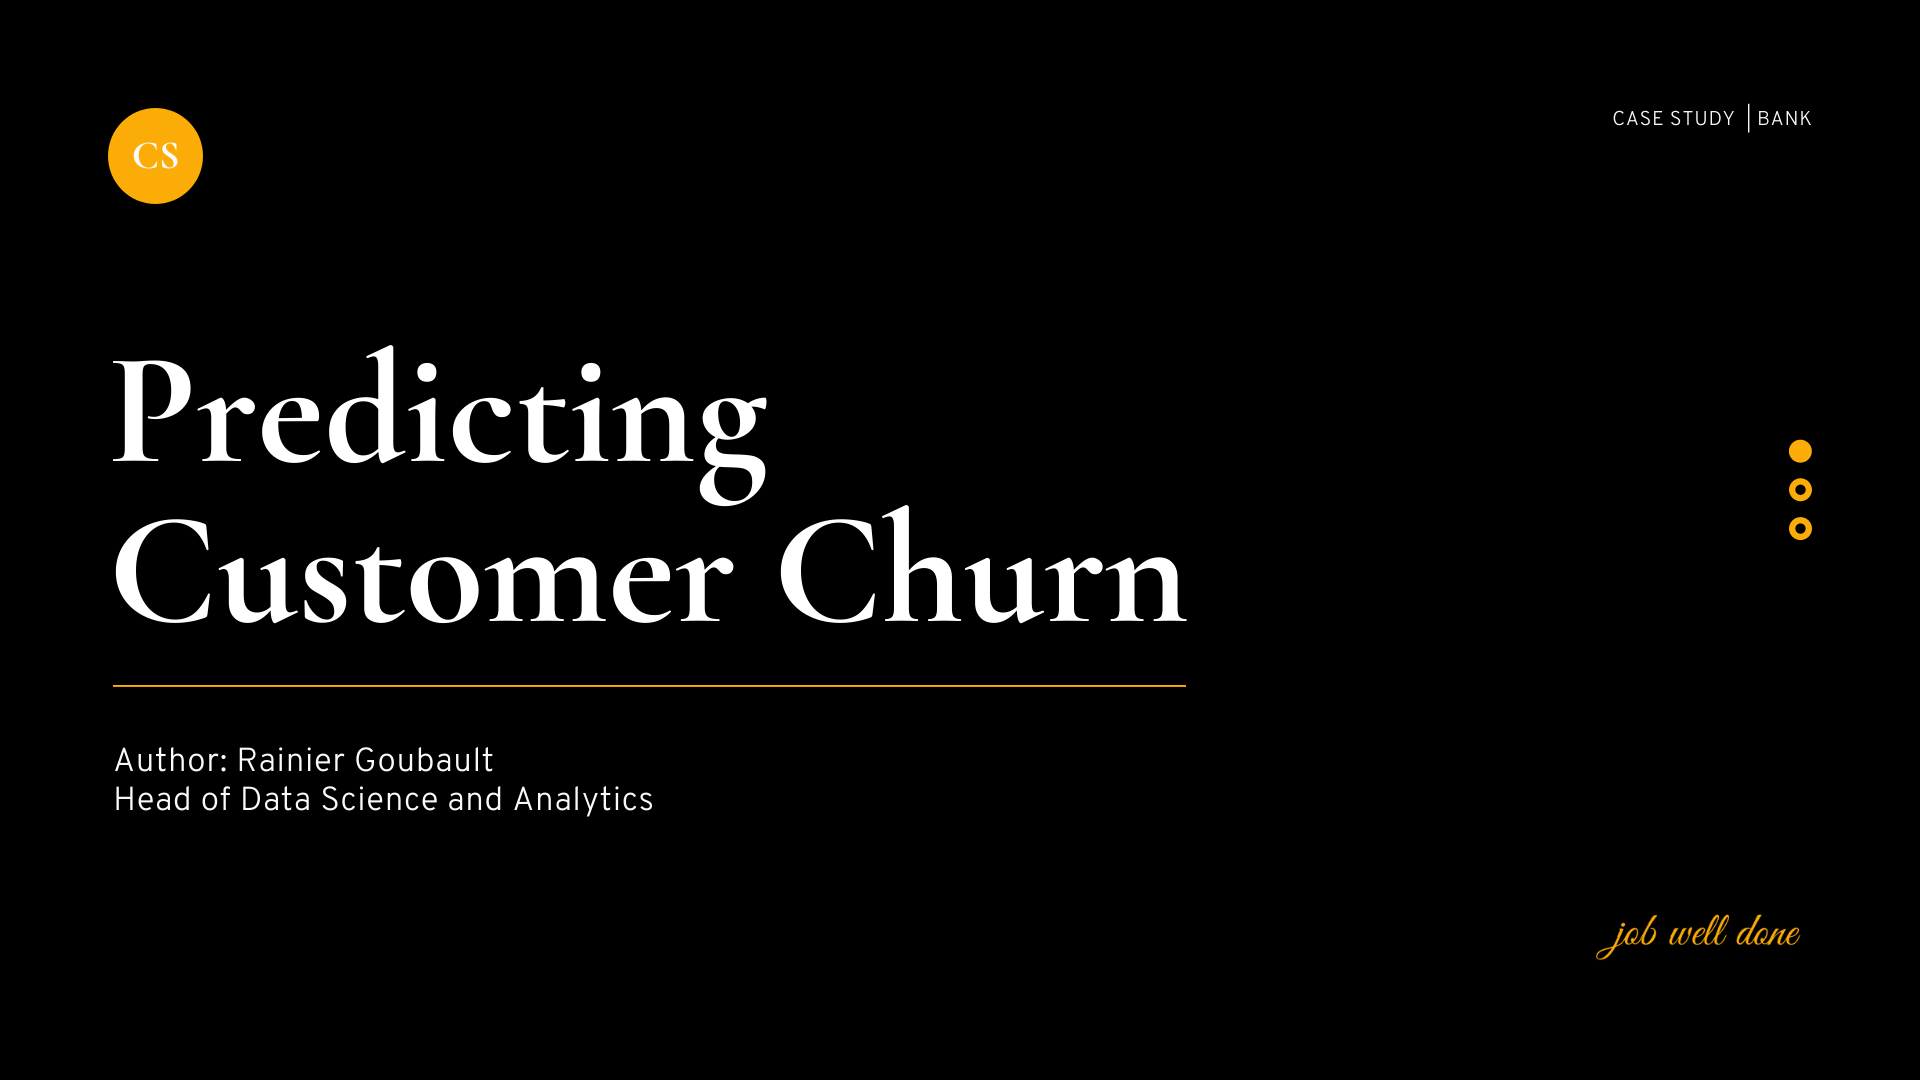

###### LinkedIn: https://www.linkedin.com/in/rainiergoubault/

###### Dataset: https://www.kaggle.com/santoshd3/bank-customers

# Business Objective:

A banking company has a churn problem as 20% of it's customers churned in the last month. Banking Co. has contracted job well done on a project to build a predictive model that meets the following business requirements:

1. Identify and visualize which factors contribute to customer churn.
2. Build a re-usable prediction model pipeline to classify customer churn risk - whether a customer will churn or not, thus making it easier for the bank to target these 'high-risk' customers as a part of its customer rentention efforts.
3. Explaination of the relative influence that each predictor has on the overall model predictions.
4. Suggest potential solutions to reducing customer churn.


# Executive Summary:

Banking Co. provided select, historical data on 10,000 customers including an indicator as to whether each customer churned. After analyzing and transforming the data, we optimized several classification models. Each model was trained on 80% of the historical data and then asked to predict churn scores on the remaining 20% test data. Each model was compared with the previous best model with model LogReg-Poly performing the best.

### Best Model Summary - LogReg-Poly:

**Target Variable:** 

    - 'Exited'

**Key Metrics:**
    
    - 85.103% mean CV ROC-AUC score
    - 88.208% ROC-AUC test score
    - 80.165% Precision test score
    - 52.575% Recall test score
    
This model will be socialized with Banking Co. and refined based on feedback before moving towards deployment.

# Introduction:

## What is churn?
Churn is defined as when customers discontinue doing business with a company.

## Why is churn important?
Most companies have a large number of customers and can't afford to devote much time and resources for individual customer retention. However, if a company could forecast which customers are most likely to leave ahead of time, it could focus its customer rentention efforts on these 'high-risk' churn customers.

As a result, by addressing customer churn, these companies may not only preserve their market position, but also grow and thrive. A company key focus for success is reducing client attrition and implementing an effective retention strategy.

# 1.1 Import Libraries

In [1]:
# Warning
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
import numpy as np 
import pandas as pd

# Statistics
from scipy import stats
from scipy.stats import norm, skew
from scipy.stats import mannwhitneyu

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import cufflinks as cf

import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from plotly.offline import iplot
from plotly.subplots import make_subplots

# Preprocessing 
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score

# Metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score


# Set visualiation options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style('white')

import plotly.io as pio
pio.renderers.default = 'notebook_connected'

cf.go_offline()

# Set notebook options
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.max_rows', 100) # display 100 rows

# Set pipeline display options
from sklearn import set_config
set_config(display='diagram')

%load_ext watermark

# Check the version history of libraries imported
print('Libraries version:')
%watermark -iv

Libraries version:
plotly    : 5.4.0
numpy     : 1.21.4
sklearn   : 1.0.1
cufflinks : 0.17.3
scipy     : 1.7.3
pandas    : 1.3.4
matplotlib: 3.5.0
seaborn   : 0.11.2
json      : 2.0.9



# 1.2 Import Data

In [2]:
raw_data = pd.read_csv('../02-data/customer-churn-bank-rawdata.csv')
df = raw_data.copy()
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [3]:
# Check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### **First Impresssions:**

- The data contains 10,000 entries (i.e. rows). Each entry represents a unique customer.
- The data contains 14 features (i.e. columns). Each feature represents a attribute about the customer.
- The data contains no missing values
- The data contains 11 numerical features and 3 categorical features.

# 2. Exploratory Data Analysis

## 2.1 Duplicate Values

In [4]:
# Check for duplicate customers
dups = df[df.duplicated(subset=['CustomerId'])==True]
print(f'{dups.shape[0]} duplicate CustomerIds found')

0 duplicate CustomerIds found


## 2.2 Constant Values

In [5]:
# Check for constant values
constant_values = df.nunique()
constant_values = [i for i,v in enumerate(constant_values) if v ==1]
constant_values

[]

- The data contains no contant values.

## 2.3 Unique Values

In [6]:
# Find how many unique values numerical features have
for feature in df.select_dtypes(include='number').columns:
    print(f'{feature} feature has {df[feature].nunique()} unique values.')

RowNumber feature has 10000 unique values.
CustomerId feature has 10000 unique values.
CreditScore feature has 460 unique values.
Age feature has 70 unique values.
Tenure feature has 11 unique values.
Balance feature has 6382 unique values.
NumOfProducts feature has 4 unique values.
HasCrCard feature has 2 unique values.
IsActiveMember feature has 2 unique values.
EstimatedSalary feature has 9999 unique values.
Exited feature has 2 unique values.


- We will not require the first 2 attributes as they're unique to each customer. We will drop them from the data.
- A few numerical features have binary values, lets convert their data type to categorical for EDA.

In [7]:
# Drop unique values from data
df.drop(['RowNumber', 'CustomerId'], axis=1, inplace=True)

In [8]:
# Convert data typs to categorical
obj_features = ['HasCrCard', 'IsActiveMember']

for feature in obj_features:
    df[feature] = df[feature].astype('object')

In [9]:
# Find how many unique values categorical features have
for feature in df.select_dtypes(include='object').columns:
    print(f'{feature} feature has {df[feature].nunique()} unique values.')

Surname feature has 2932 unique values.
Geography feature has 3 unique values.
Gender feature has 2 unique values.
HasCrCard feature has 2 unique values.
IsActiveMember feature has 2 unique values.


- We will not require the first attribute 'Surname' as its a unique id specific to each customer. We will drop 'Surname' from the data.

In [10]:
df.drop('Surname', axis=1, inplace=True)

## 2.4 Missing Values

In [11]:
missing_values = df.isna().sum()
missing_values

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- As we saw above, the data contains no missing values.

# 2.5 Target Feature

In [12]:
target_count = df['Exited'].count()
target_count

10000

In [13]:
target_value_counts = df['Exited'].value_counts().to_frame()
target_value_counts

Exited
0    7963
1    2037

In [14]:
names = ['Retained', 'Churn']
fig = px.pie(target_value_counts, names=names, values='Exited', title='<b>Churn Distribution<b>')
fig

### Target Feature Summary:

- Most, 79.6% of the customers were retained.
- 20.4% (2,037) of customers churned in the last month out of 10,000 total customers.
- The target feature is imbalanced.

# 2.6 Numerical Features

In [15]:
# Get numerical features
num = df.drop('Exited', axis=1).select_dtypes(include='number').columns

In [16]:
# Look at numerical features
df[num].head()

CreditScore  Age  Tenure    Balance  NumOfProducts  EstimatedSalary
0          619   42       2       0.00              1        101348.88
1          608   41       1   83807.86              1        112542.58
2          502   42       8  159660.80              3        113931.57
3          699   39       1       0.00              2         93826.63
4          850   43       2  125510.82              1         79084.10

## 2.6.1 Univariate Analysis

#### Statistical Summary

In [17]:
df[num].describe().T.style.background_gradient(subset=['count', 'mean','std','50%'], cmap='RdPu').format('{:.2f}')

#### Histogram Distribution

In [18]:
fig = df[num].iplot(kind='hist', subplots=True, bins=50, 
                    title='<b>Histogram Distribution of Numerical Features<b>')
fig

#### Skew & Kurtosis

#### Skew

In [19]:
skew_limit = 0.75
skew_vals = df[num].skew()
skew_feats = skew_vals[abs(skew_vals) > skew_limit]
skew_feats = pd.DataFrame(skew_feats, columns=['Skew'])
skew_feats.sort_values(by='Skew', ascending=False, inplace=True)
skew_feats

Skew
Age  1.01132

#### Kurtosis

In [20]:
kurt_limit = 1
kurt_vals = df[num].kurt()
kurt_feats = kurt_vals[abs(kurt_vals) > kurt_limit]
kurt_feats = pd.DataFrame(kurt_feats, columns=['Kurt'])
kurt_feats.sort_values(by='Kurt', ascending=False, inplace=True)
kurt_feats

Kurt
Age              1.395347
Tenure          -1.165225
EstimatedSalary -1.181518
Balance         -1.489412

## 2.6.2 Bivariate Analysis (vs. Target Feature)

Let's examine the influence of numerical features on the target variable

#### Boxplots Distribution

In [21]:
# Get numerical features + target feature to list
num_target = df.select_dtypes(include='number').columns

# Check the list of features
num_target

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [22]:
for feature in df[num]:
    fig = px.box(df[num_target], x='Exited', y=feature,
                 title=f'<b>{feature} Distribution by Churn<b>')
    fig.show()

#### We note the following:

1. **CreditScore**: A customers credit score doesn't seem to affect churn. There is no significance difference in credit score distribution between retained and churned customers. 
2. **Age**: Older customers are more likely to churn than younger customers.
3. **Tenure**: Customers who spent little time with the bank and customers who have been with the bank the longest 
    are more likely to churn than those with an average tenure.
4. **Balance**: Customers with higher balances are more likely to churn.
5. **NumOfProducts**: The number of products a customer has with the bank doesn't seem to influence churn.
6. **EstimatedSalary**: Customers salary does not seem to affect churn.

## 2.6.3 Relationships

#### Correlation Matrix + Heatmap

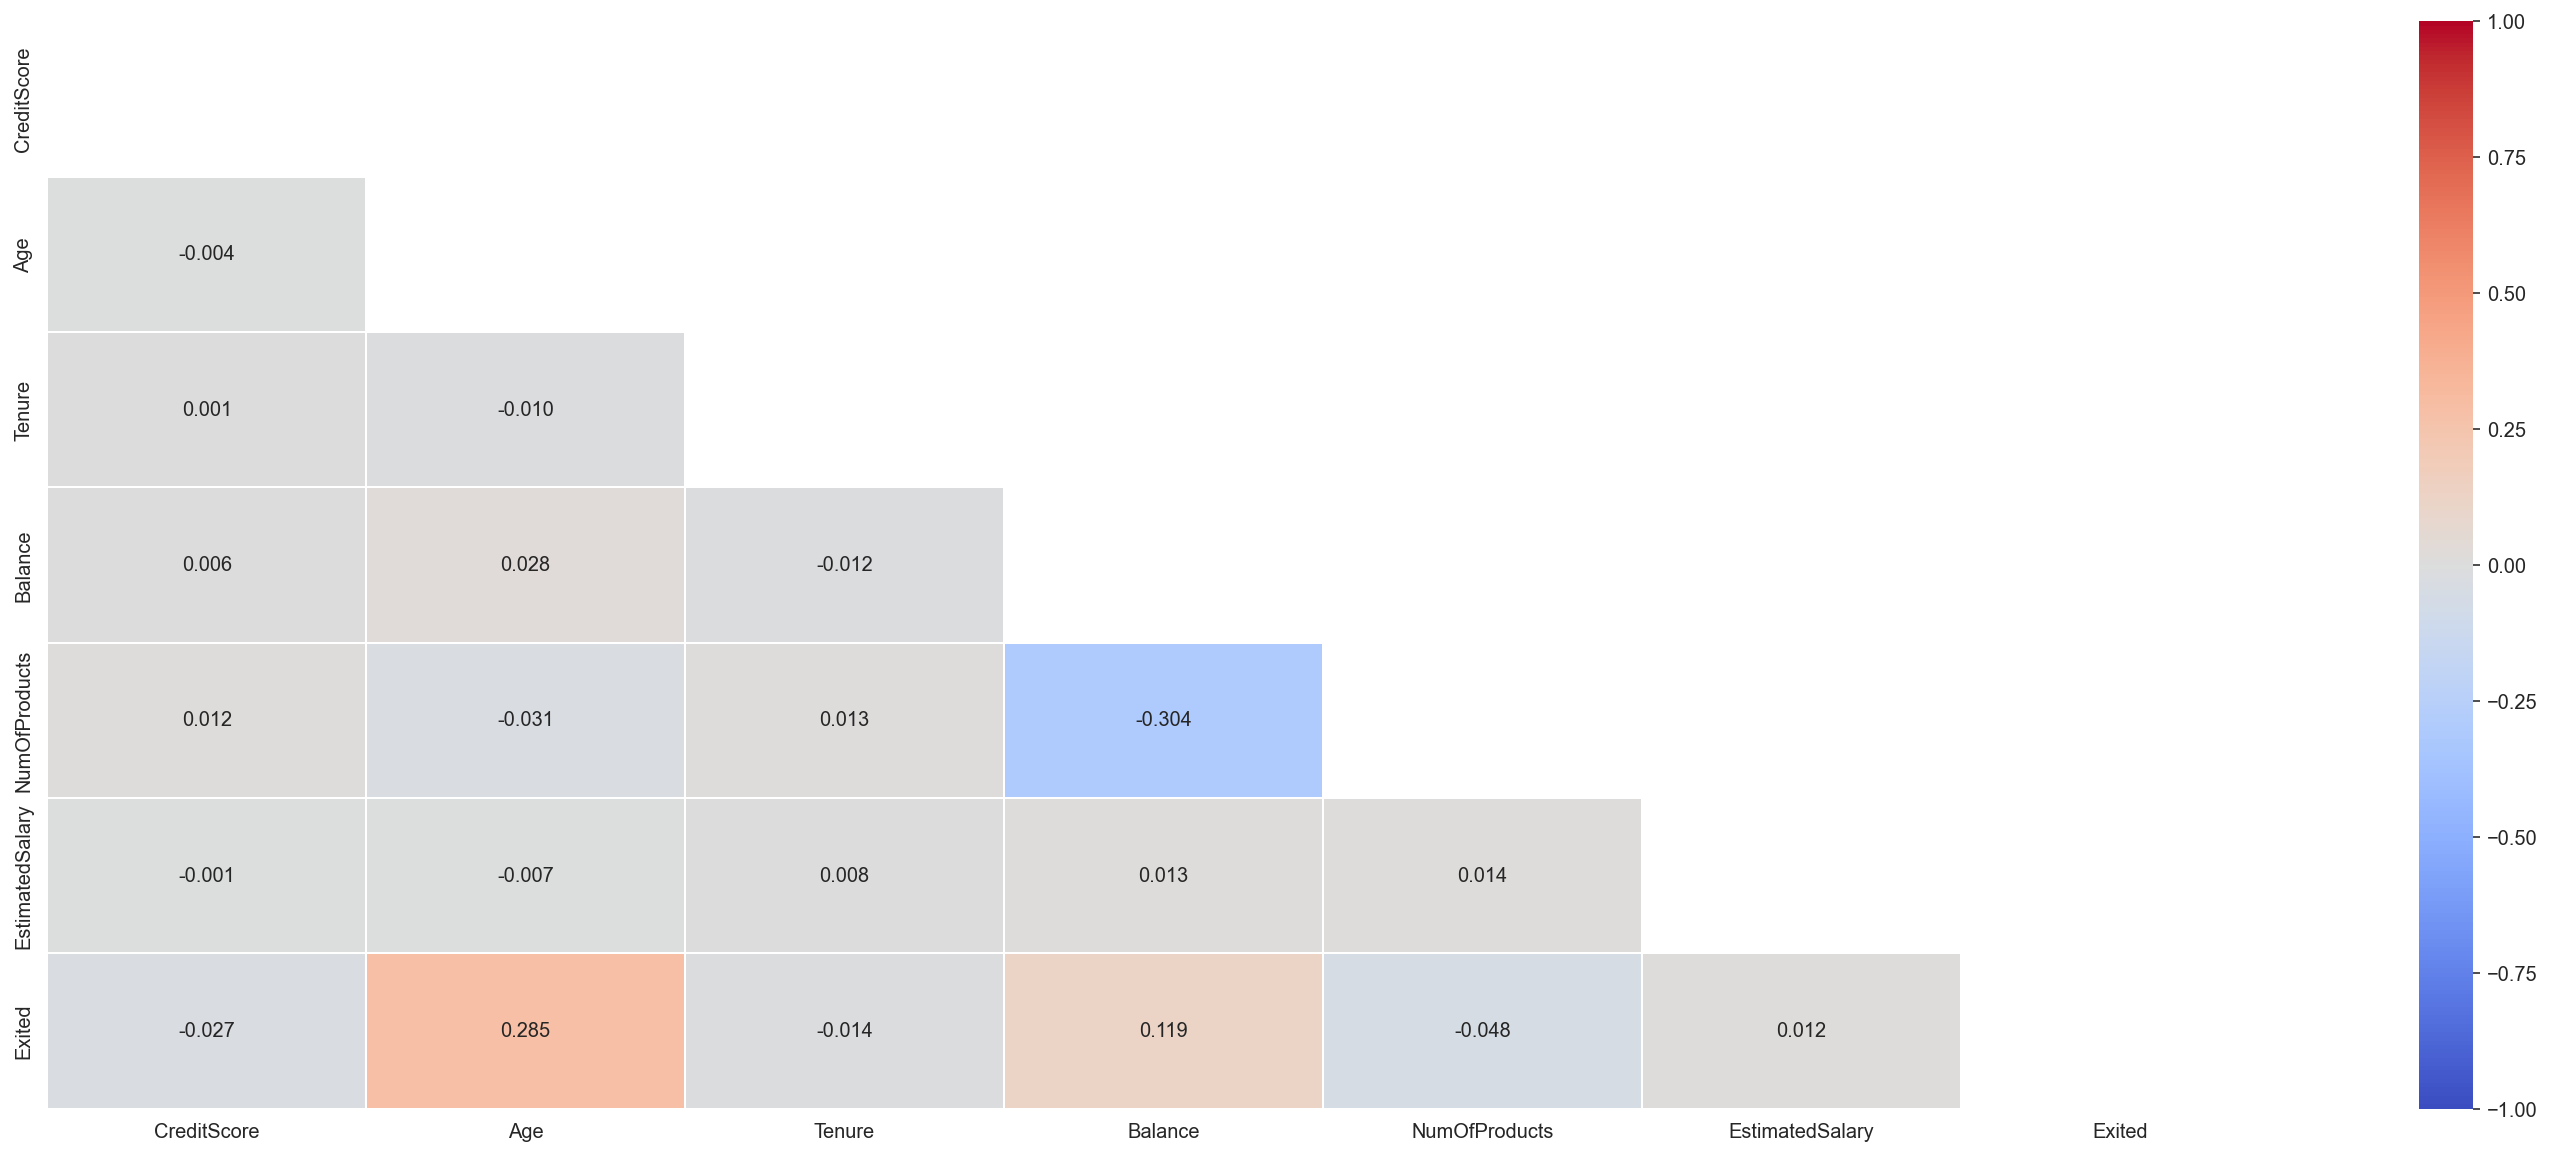

In [23]:
plt.figure(figsize=(25, 10))

corr_matrix = df[num_target].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

ax = sns.heatmap(corr_matrix, 
                 mask=mask, 
                 xticklabels=corr_matrix.columns, 
                 yticklabels=corr_matrix.columns, 
                 annot=True,
                 fmt='.3f',
                 linewidths=.2, 
                 cmap='coolwarm', 
                 vmin=-1, vmax=1);

#### We note the following:

- Based on the matrix, we observe weak level correlation between the numerical features  and target feature
- A few features has negative correlation with the target feature
        - 'CreditScore', 'Tenure', and 'NumOfProducts'

# 2.7 Categorical Features

In [24]:
# Get categorical features
cat = df.drop('Exited', axis=1).select_dtypes(include='object').columns

In [25]:
# Look at the categorical features
df[cat].head()

Geography  Gender HasCrCard IsActiveMember
0    France  Female         1              1
1     Spain  Female         0              1
2    France  Female         1              0
3    France  Female         0              0
4     Spain  Female         1              1

## 2.7.1 Univariate Analysis

#### Statistical Summary

In [26]:
df[cat].describe().T.style.background_gradient(subset=['count', 'unique','freq'], cmap='RdPu')

#### Unique Values

In [27]:
for feature in df[cat]:
    print(f'\n{feature} feature has {df[feature].nunique()} unique values.')
    print(f'{df[feature].unique()}\n')
    print('-' * 75)


Geography feature has 3 unique values.
['France' 'Spain' 'Germany']

---------------------------------------------------------------------------

Gender feature has 2 unique values.
['Female' 'Male']

---------------------------------------------------------------------------

HasCrCard feature has 2 unique values.
[1 0]

---------------------------------------------------------------------------

IsActiveMember feature has 2 unique values.
[1 0]

---------------------------------------------------------------------------


#### Histogram Distribution

In [28]:
fig = df[cat].iplot(kind='hist', subplots=True,
                      title='<b>Histogram Distribution of Categorical Features<b>')
fig

#### We note the following:

**Geography**: 
- Majority of customers are French (5,014), then German (2,509) and Spanish (2,477).

**Gender**: 
- There are more male customers (5,457) then female customers (4,543).

**HasCrCard**: 
- Majority of customers have a credit card with the bank (7,055) than not (2,945).

**IsActiveMember**: 
- Slightly more customers who are active (5,151) than inactive members (4,849).

## 2.7.2 Bivariate Analysis (vs. Target Feature)

#### Histogram Distribution

In [29]:
for value, feature in enumerate(df[cat]):
    fig = px.histogram(df[feature], x=feature, color=df['Exited'], barmode='group', 
                       title=f'<b>{feature} by Churn<b>')
    fig.show()

#### We note the following:

**Geography**: 
- German customers churn the most, followed by French and Spanish customers.
   
**Gender**: 
- Female customers are more likely to churn than male customers.
    
**HasCrCard**: 
- Customers with credit cards are more likely to churn than those without. Since a majority of customer have a credit cards this is not a-typical.
                
**IsActiveMember**: 
- Customers who are not active memebers churn more than active memebers.

## 2.7.3 Relationship

#### Mutual Info Score

In [30]:
from sklearn.metrics import mutual_info_score

def cat_mut_inf(series):
    return mutual_info_score(series, df['Exited']) 

cat_mut_info = df[cat].apply(cat_mut_inf) 
cat_mut_info = cat_mut_info.sort_values(ascending=False).to_frame(name='Mutual Info Score') 
cat_mut_info

Mutual Info Score
Geography                0.014017
IsActiveMember           0.012291
Gender                   0.005652
HasCrCard                0.000025

# 3. Data Preparation

In [31]:
df = raw_data.copy()
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [33]:
df.shape

(10000, 14)

## 3.1 Feature Engineering

We seek to add new features to the data that are likely to have an impact on the probability of churning. 

We'll add 3 new features to the data:

1. **BalanceSalaryRatio** 
    - The ratio of customers bank 'Balance' vs. customers 'EstimatedSalary'.

2. **TenureByAge** 
    - 'Tenure' is a function of 'Age', we'll standardize 'Tenure' over 'Age'.
        
3. **CreditByAge** 
    - 'CreditScore' by 'Age' to  take into account credit behaviour by adult life.

In [34]:
df['BalanceSalaryRatio'] = df['Balance'] / df['EstimatedSalary']
df['TenureByAge'] = df['Tenure'] / df['Age']
df['CreditScoreGivenAge'] = df['CreditScore'] / df['Age']

In [35]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  BalanceSalaryRatio  TenureByAge  \
0        101348.88       1            0.000000     0.047619   
1        112542.58       0            0.744677     0.024390   
2        113931.57       1            1.401375     0.190476   
3         93826.63       0            0.000000     0.025641   
4         79084.10       0            1.587055     0.046512   

   CreditScoreGivenAge  
0            14.738095  
1            14.829268  
2            11.952381  
3            17.923077  
4            19.767442

## 3.2 Split the data into train and test set

We'll separate the data into a train set and test set, getting 10% of the data for the test set.

In [36]:
train, test = train_test_split(df, test_size=.10, random_state=999)
print('The shape of the train set:', train.shape)
print('The shape of the test set:', test.shape)

The shape of the train set: (9000, 17)
The shape of the test set: (1000, 17)


- The data was split into train and test set.
- Train set contain 9000 rows and is what we'll use to train the model.
- Test set contain 1000 rows and is what we'll use (i.e. new data) to test our already trained model.

In [37]:
# Save train and test set to csv
train.to_csv('../02-data/customer-churn-bank-trainingset.csv', index=False)
test.to_csv('../02-data/customer-churn-bank-testingset.csv', index=False)

## 3.3 Parition the train data into features (X) and target (y)

In [38]:
train.head()

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
7553       7554    15792107      Black          719     Spain  Female   35   
6033       6034    15759966  Chiemenam          612     Spain  Female   36   
6757       6758    15766667    Langler          717     Spain    Male   36   
2337       2338    15660688       King          701     Spain  Female   35   
9578       9579    15810891    Lorenzo          662    France    Male   34   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
7553       8       0.00              1          1               1   
6033       5  119799.27              2          1               0   
6757       2  102989.83              2          0               1   
2337       9       0.00              2          0               0   
9578       2  117731.79              2          0               1   

      EstimatedSalary  Exited  BalanceSalaryRatio  TenureByAge  \
7553        165162.40       0            0.000000     0.228571   
6033        159416.58       0            0.751486     0.138889   
6757         49185.57       0            2.093903     0.055556   
2337        170996.86       0            0.000000     0.257143   
9578         55120.79       0            2.135887     0.058824   

      CreditScoreGivenAge  
7553            20.542857  
6033            17.000000  
6757            19.916667  
2337            20.028571  
9578            19.470588

In [39]:
X = train.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = train['Exited']
print('The shape of X:', X.shape)
print('The shape of y:', y.shape)

The shape of X: (9000, 13)
The shape of y: (9000,)


## 3.4 Split into training and testing sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=999)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(7200, 13) (1800, 13)
(7200,) (1800,)


# 4. Metric Selection

As we saw during EDA, the target feature **'Exited'** is imbalanced. 

For an imbalanced classification problem, there are a number of metrics to consider:

1. **Receiver Operating Characteristic Area Under the Curve (ROC AUC)**: 
        A measure between 0 and 1 comparing the performance of the classifier when predicting probabilities 
        across a range of thresholds.
2. **Precision Score**: 
        The number of true positives divided by the total number of positives predicted.
3. **Recall Score**: 
        The number of true positives divided by the total number of actual positives in the data.
4. **F1 Score**: 
        Harmonic mean of precision and recall.

The exact metric used and the threshold that our model needs to reach depends on the business need. We can tune the model to some extent to optimize for different metrics. 

We'll use:

1. **ROC AUC** metric to evaluate the model.
2. We'll also look at the **Precision** and **Recall** metrics on the test set.


# 5. Model Selection

We will try the following models:
    
1. **Linear Model**
    
        - Logistic Regression
        - Logistic Regression w/ Polynominal Features

2. **Ensemble Model**

        - Random Forest
    
3. **Boosting Model**

        - History Gradient Boosting

In [41]:
def assign_class(y_pred_prob, dt=0.5):
    """
    Calculates churn predictions based on any decision threshold level 
    using a classification model's predicted probability scores.
    
    Parameters:
    - y_pred_prob (array): predicted churn probabilities
    - dt (float): decision threshold value between 0 and 1. Represents 
      predicted probability at which postive class (churn) should be assigned.

    Returns:
    - scores (dict): includes 5 evaluation metrics for model type
    """
    return [1 if y >= dt else 0 for y in y_pred_prob]

## 5.1.1 - Model 1: LogReg

In [42]:
%%time

# Define numerical features data preprocessing
standard_scaler = StandardScaler()
num_preprocessor = Pipeline([('scale', standard_scaler)])

# Define categorical features data preprocessing
ohe = OneHotEncoder(handle_unknown='ignore')
cat_preprocessor = Pipeline([('encode', ohe)])

# Combine numerical and categorical preprocessing 
ct = ColumnTransformer([('numerical', num_preprocessor, selector(dtype_include='number')),
                        ('categorical', cat_preprocessor, selector(dtype_include='object'))])

# Instantiate model
logreg = LogisticRegression(solver='liblinear', random_state=999)

# Define model pipeline
logreg_model = Pipeline([('preprocessing', ct), ('model', logreg)])

# Fit model pipeline
logreg_model.fit(X_train, y_train)
    
# Predict model pipeline
logreg_pred = logreg_model.predict(X_test)
logreg_predprob = logreg_model.predict_proba(X_test)[:,1]

logreg_roc_auc = round(roc_auc_score(y_test, logreg_predprob) * 100, 4)
logreg_precision = round(precision_score(y_test, logreg_pred) * 100, 4)
logreg_recall = round(recall_score(y_test, logreg_pred) * 100, 4)

# Display model test score
model_name = 'Default_LogReg'
print(f'{model_name} model\n')
print(f'ROC-AUC test score: {logreg_roc_auc}%')
print(f'Precision test score: {logreg_precision}%')
print(f'Recall test score: {logreg_recall}%')
print()

Default_LogReg model

ROC-AUC test score: 78.4133%
Precision test score: 73.7705%
Recall test score: 24.3902%

CPU times: user 91.2 ms, sys: 11.4 ms, total: 103 ms
Wall time: 46.6 ms


In [43]:
%%time

# Define model evaluation strategy
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=999)
metric = 'roc_auc'

# Cross-Validate model 
logreg_cvscore = round((cross_val_score(logreg_model, X_train, y_train, scoring=metric, cv=skfold, n_jobs=-1, 
                                        error_score='raise', verbose=0) * 100).mean(), 4)

# Display model score
print(f'The {model_name} mean CV ROC-AUC score: {logreg_cvscore}%')
print()

The Default_LogReg mean CV ROC-AUC score: 76.7057%

CPU times: user 224 ms, sys: 115 ms, total: 339 ms
Wall time: 1.66 s


### Confusion Matrix

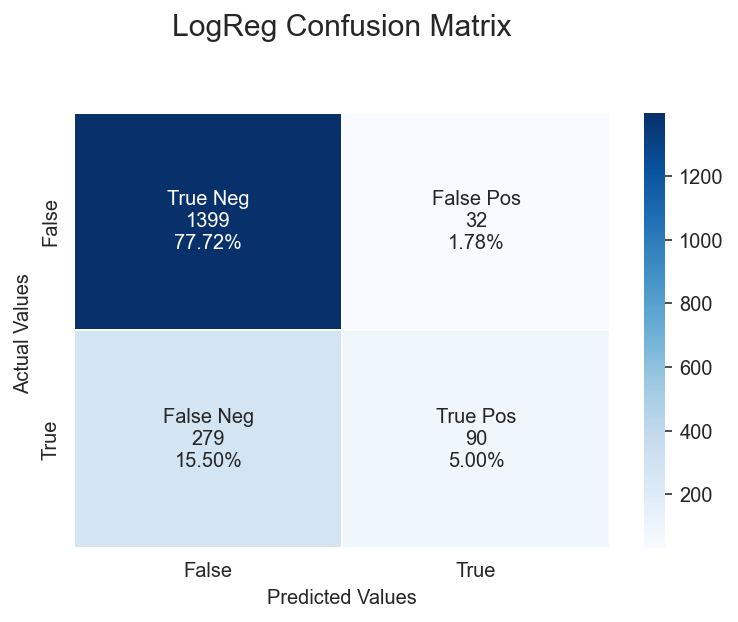

In [44]:
logreg_cm = confusion_matrix(y_test, logreg_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_sum = ['{0:0.0F}'.format(value) for value in logreg_cm.flatten()]

group_percent = ['{0:.2%}'.format(value) for value in 
                 logreg_cm.flatten()/np.sum(logreg_cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
         zip(group_names, group_sum, group_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(logreg_cm, annot=labels, fmt='', linewidths=0.75, cmap='Blues')

ax.set_title('LogReg Confusion Matrix\n\n', size=15);
ax. set_xlabel("Predicted Values")
ax. set_ylabel('Actual Values ');
#
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True']);

In [45]:
logreg_cr = classification_report(y_test, logreg_pred)
print(logreg_cr)

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1431
           1       0.74      0.24      0.37       369

    accuracy                           0.83      1800
   macro avg       0.79      0.61      0.63      1800
weighted avg       0.81      0.83      0.79      1800



## Model Results

In [46]:
logreg_model_result = pd.DataFrame(logreg_cvscore, columns=['CV ROC-AUC'], index=['Default_LogReg'])
logreg_model_result['ROC-AUC'] = logreg_roc_auc
logreg_model_result['Precision'] = logreg_precision
logreg_model_result['Recall'] = logreg_recall
logreg_model_result

CV ROC-AUC  ROC-AUC  Precision   Recall
Default_LogReg     76.7057  78.4133    73.7705  24.3902

## 5.1.2 - Model: LogReg-Poly

In [47]:
%%time

# Define numerical features data preprocessing
standard_scaler = StandardScaler()
num_preprocessor = Pipeline([('scale', standard_scaler)])

# Define categorical features data preprocessing
ohe = OneHotEncoder(handle_unknown='ignore')
cat_preprocessor = Pipeline([('encode', ohe)])

# Combine numerical and categorical preprocessing 
ct = ColumnTransformer([('numerical', num_preprocessor, selector(dtype_include='number')),
                        ('categorical', cat_preprocessor, selector(dtype_include='object'))])

# Instantiate model
logreg = LogisticRegression(solver='liblinear', random_state=999)

# Define model pipeline
logreg_poly_model = Pipeline([('preprocessing', ct), 
                              ('feature_engineering', PolynomialFeatures(degree=2)),
                              ('model', logreg)])

# Fit model pipeline
logreg_poly_model.fit(X_train, y_train)
    
# Predict model pipeline
logreg_poly_pred = logreg_poly_model.predict(X_test)
logreg_poly_predprob = logreg_poly_model.predict_proba(X_test)[:,1]

logreg_poly_roc_auc = round(roc_auc_score(y_test, logreg_poly_predprob) * 100, 4)
logreg_poly_precision = round(precision_score(y_test, logreg_poly_pred) * 100, 4)
logreg_poly_recall = round(recall_score(y_test, logreg_poly_pred) * 100, 4)

# Display model test score
model_name = 'Default_LogReg-Poly'
print(f'{model_name} model\n')
print(f'ROC-AUC test score: {logreg_poly_roc_auc}%')
print(f'Precision test score: {logreg_poly_precision}%')
print(f'Recall test score: {logreg_poly_recall}%')
print()

Default_LogReg-Poly model

ROC-AUC test score: 87.9713%
Precision test score: 79.918%
Recall test score: 52.8455%

CPU times: user 780 ms, sys: 15.9 ms, total: 796 ms
Wall time: 553 ms


In [48]:
%%time
# Cross-Validate model
logreg_poly_cvscore = round((cross_val_score(logreg_poly_model, X_train, y_train, scoring=metric, cv=skfold, 
                                             n_jobs=-1, error_score='raise', verbose=0) * 100).mean(), 4)

# Display model score
print(f'The {model_name} mean CV ROC-AUC score: {logreg_poly_cvscore}%')
print()

The Default_LogReg-Poly mean CV ROC-AUC score: 85.0504%

CPU times: user 317 ms, sys: 59.1 ms, total: 376 ms
Wall time: 1.59 s


### Confusion Matrix

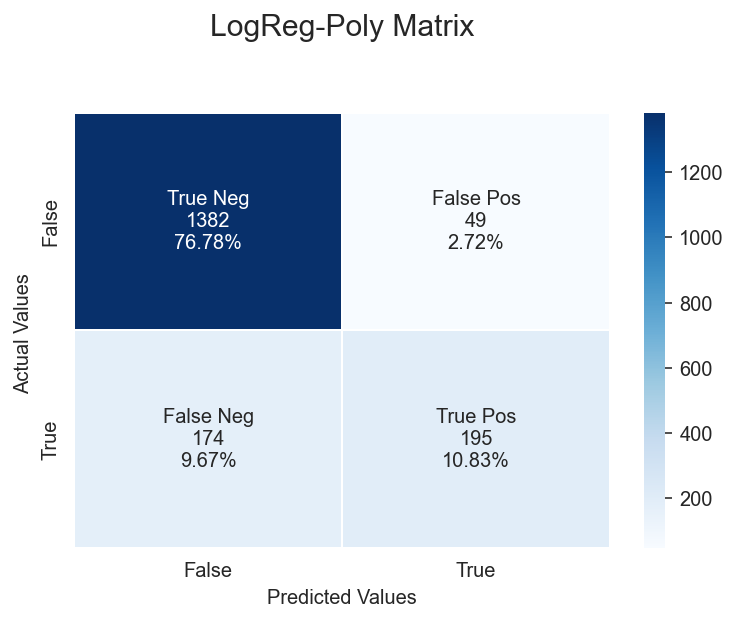

In [49]:
logreg_poly_cm = confusion_matrix(y_test, logreg_poly_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_sum = ['{0:0.0F}'.format(value) for value in logreg_poly_cm.flatten()]

group_percent = ['{0:.2%}'.format(value) for value in 
                 logreg_poly_cm.flatten()/np.sum(logreg_poly_cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
         zip(group_names, group_sum, group_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(logreg_poly_cm, annot=labels, fmt='', linewidths=0.75, cmap='Blues')

ax.set_title('LogReg-Poly Matrix\n\n', size=15);
ax. set_xlabel("Predicted Values")
ax. set_ylabel('Actual Values ');
#
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True']);

In [50]:
logreg_poly_cr = classification_report(y_test, logreg_poly_pred)
print(logreg_poly_cr)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1431
           1       0.80      0.53      0.64       369

    accuracy                           0.88      1800
   macro avg       0.84      0.75      0.78      1800
weighted avg       0.87      0.88      0.87      1800



## Model Results

In [51]:
logreg_poly_model_result = pd.DataFrame(logreg_poly_cvscore, columns=['CV ROC-AUC'], index=['Default_LogReg-Poly'])
logreg_poly_model_result['ROC-AUC'] = logreg_poly_roc_auc
logreg_poly_model_result['Precision'] = logreg_poly_precision
logreg_poly_model_result['Recall'] = logreg_poly_recall
logreg_poly_model_result

CV ROC-AUC  ROC-AUC  Precision   Recall
Default_LogReg-Poly     85.0504  87.9713     79.918  52.8455

## Compare Models

In [52]:
model_results = pd.concat([logreg_model_result, logreg_poly_model_result], axis=0)
model_results.sort_values(by=['CV ROC-AUC'], ascending=False, inplace=True)
model_results

CV ROC-AUC  ROC-AUC  Precision   Recall
Default_LogReg-Poly     85.0504  87.9713    79.9180  52.8455
Default_LogReg          76.7057  78.4133    73.7705  24.3902

- Whoa! Adding Polynominal Feature to the pipeline dramatically improved the LogReg model.

## 5.1.3 - Model: RandomForest

In [53]:
%%time

# Define numerical features data preprocessing
#standard_scaler = StandardScaler()
#num_preprocessor = Pipeline([('scale', standard_scaler)])


# Define categorical features data preprocessing
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
cat_preprocessor = Pipeline([('ordinal_encode', oe)])

# Combine numerical and categorical preprocessing 
ct = ColumnTransformer([('categorical', cat_preprocessor, selector(dtype_include='object'))],
                       remainder='passthrough')

# Instantiate model
rf = RandomForestClassifier(random_state=999)

# Define model pipeline
rf_model = Pipeline([('preprocessing', ct),('model', rf)])

# Fit model pipeline
rf_model.fit(X_train, y_train)
    
# Predict model pipeline
rf_pred = rf_model.predict(X_test)
rf_predprob = rf_model.predict_proba(X_test)[:,1]

rf_roc_auc = round(roc_auc_score(y_test, rf_predprob) * 100, 4)
rf_precision = round(precision_score(y_test, rf_pred) * 100, 4)
rf_recall = round(recall_score(y_test, rf_pred) * 100, 4)

# Display model text score
model_name = 'Default_RandomForest'
print(f'{model_name} model\n')
print(f'ROC-AUC test score: {rf_roc_auc}%')
print(f'Precision test score: {rf_precision}%')
print(f'Recall test score: {rf_recall}%')
print()

Default_RandomForest model

ROC-AUC test score: 85.9377%
Precision test score: 78.733%
Recall test score: 47.1545%

CPU times: user 1.03 s, sys: 12.1 ms, total: 1.04 s
Wall time: 883 ms


In [54]:
%%time

# Cross-Validate model 
rf_cvscore = round((cross_val_score(rf_model, X_train, y_train, scoring=metric, cv=skfold, n_jobs=-1, 
                                    error_score='raise', verbose=0) * 100).mean(), 4)

# Display model score
print(f'The {model_name} mean CV ROC-AUC score: {rf_cvscore}%')
print()

The Default_RandomForest mean CV ROC-AUC score: 84.2341%

CPU times: user 38.4 ms, sys: 7.83 ms, total: 46.2 ms
Wall time: 2.2 s


### Confusion Matrix

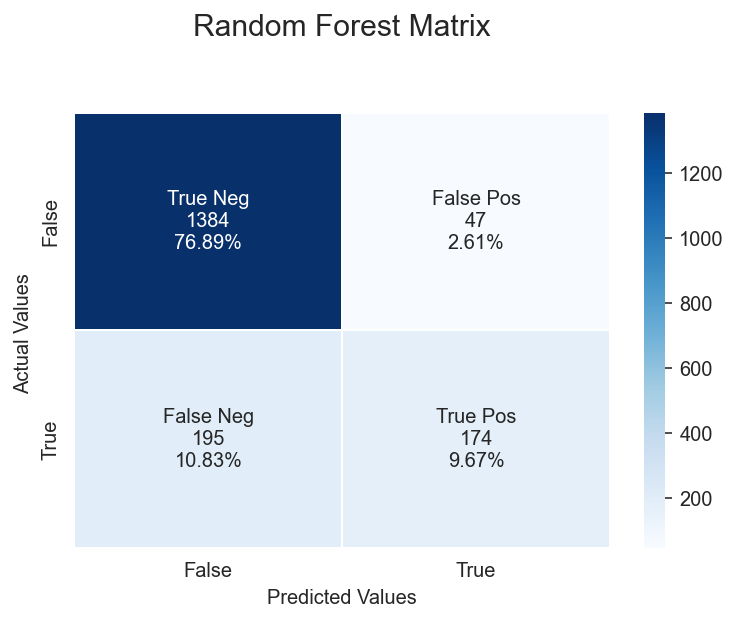

In [55]:
rf_cm = confusion_matrix(y_test, rf_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_sum = ['{0:0.0F}'.format(value) for value in rf_cm.flatten()]

group_percent = ['{0:.2%}'.format(value) for value in 
                 rf_cm.flatten()/np.sum(rf_cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
         zip(group_names, group_sum, group_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(rf_cm, annot=labels, fmt='', linewidths=0.75, cmap='Blues')

ax.set_title('Random Forest Matrix\n\n', size=15);
ax. set_xlabel("Predicted Values")
ax. set_ylabel('Actual Values ');
#
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True']);

In [56]:
rf_cr = classification_report(y_test, rf_pred)
print(rf_cr)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1431
           1       0.79      0.47      0.59       369

    accuracy                           0.87      1800
   macro avg       0.83      0.72      0.75      1800
weighted avg       0.86      0.87      0.85      1800



## Model Results

In [57]:
rf_model_result = pd.DataFrame(rf_cvscore, columns=['CV ROC-AUC'], index=['Default_RandomForest'])
rf_model_result['ROC-AUC'] = rf_roc_auc
rf_model_result['Precision'] = rf_precision
rf_model_result['Recall'] = rf_recall
rf_model_result

CV ROC-AUC  ROC-AUC  Precision   Recall
Default_RandomForest     84.2341  85.9377     78.733  47.1545

## Compare Models

In [58]:
model_results = pd.concat([model_results, rf_model_result], axis=0)
model_results.sort_values(by=['CV ROC-AUC'], ascending=False, inplace=True)
model_results

CV ROC-AUC  ROC-AUC  Precision   Recall
Default_LogReg-Poly      85.0504  87.9713    79.9180  52.8455
Default_RandomForest     84.2341  85.9377    78.7330  47.1545
Default_LogReg           76.7057  78.4133    73.7705  24.3902

## 5.1.4 - Model: Hist Gradient Boosting

In [59]:
%%time

# Define numerical features data preprocessing
#standard_scaler = StandardScaler()
#num_preprocessor = Pipeline([('scale', standard_scaler)])


# Define categorical features data preprocessing
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
cat_preprocessor = Pipeline([('ordinal_encode', oe)])

# Combine numerical and categorical preprocessing 
ct = ColumnTransformer([('categorical', cat_preprocessor, selector(dtype_include='object'))],
                       remainder='passthrough')

# Instantiate model
hgb = HistGradientBoostingClassifier(random_state=999)

# Define model pipeline
hgb_model = Pipeline([('preprocessing', ct),('model', hgb)])

# Fit model pipeline
hgb_model.fit(X_train, y_train)
    
# Predict model pipeline
hgb_pred = hgb_model.predict(X_test)
hgb_predprob = hgb_model.predict_proba(X_test)[:,1]

hgb_roc_auc = round(roc_auc_score(y_test, hgb_predprob) * 100, 4)
hgb_precision = round(precision_score(y_test, hgb_pred) * 100, 4)
hgb_recall = round(recall_score(y_test, hgb_pred) * 100, 4)

# Display model test score
model_name = 'Default_HistoryGradientBoosting'
print(f'{model_name} model\n')
print(f'ROC-AUC test score: {hgb_roc_auc}%')
print(f'Precision test score: {hgb_precision}%')
print(f'Recall test score: {hgb_recall}%')
print()

Default_HistoryGradientBoosting model

ROC-AUC test score: 87.7359%
Precision test score: 78.629%
Recall test score: 52.8455%

CPU times: user 2.88 s, sys: 65.1 ms, total: 2.95 s
Wall time: 397 ms


In [60]:
%%time

# Cross-Validate model
hgb_cvscore = round((cross_val_score(hgb_model, X_train, y_train, scoring=metric, cv=skfold, n_jobs=-1, 
                             error_score='raise', verbose=0) * 100).mean(), 4)

# Display model score
print(f'The {model_name} mean CV ROC-AUC score: {hgb_cvscore}%')
print()

The Default_HistoryGradientBoosting mean CV ROC-AUC score: 84.864%

CPU times: user 196 ms, sys: 32.3 ms, total: 228 ms
Wall time: 1.08 s


### Confusion Matrix

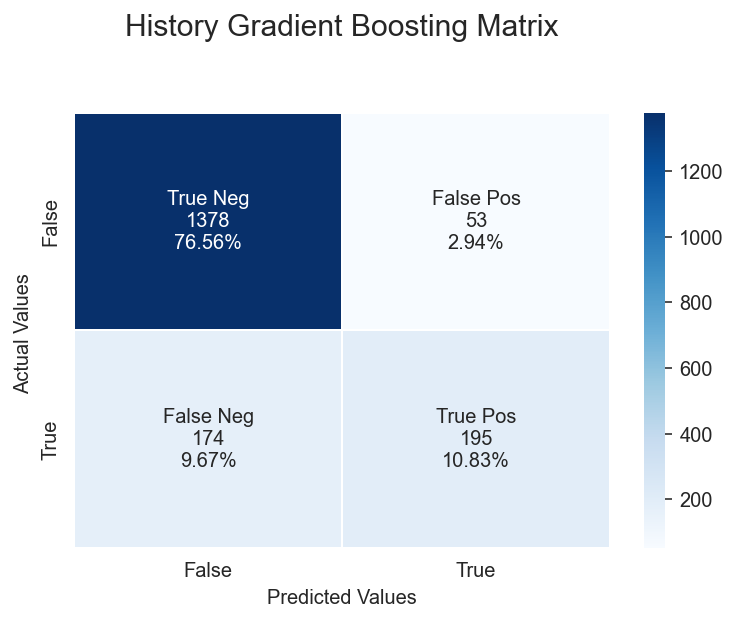

In [61]:
hgb_cm = confusion_matrix(y_test, hgb_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_sum = ['{0:0.0F}'.format(value) for value in hgb_cm.flatten()]

group_percent = ['{0:.2%}'.format(value) for value in 
                 hgb_cm.flatten()/np.sum(hgb_cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
         zip(group_names, group_sum, group_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(hgb_cm, annot=labels, fmt='', linewidths=0.75, cmap='Blues')

ax.set_title('History Gradient Boosting Matrix\n\n', size=15);
ax. set_xlabel("Predicted Values")
ax. set_ylabel('Actual Values ');
#
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True']);

In [62]:
hgb_cr = classification_report(y_test, hgb_pred)
print(hgb_cr)

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1431
           1       0.79      0.53      0.63       369

    accuracy                           0.87      1800
   macro avg       0.84      0.75      0.78      1800
weighted avg       0.87      0.87      0.86      1800



## Model Results

In [63]:
hgb_model_result = pd.DataFrame(hgb_cvscore, columns=['CV ROC-AUC'], index=['Default_HistoryGradientBoosting'])
hgb_model_result['ROC-AUC'] = hgb_roc_auc
hgb_model_result['Precision'] = hgb_precision
hgb_model_result['Recall'] = hgb_recall
hgb_model_result

CV ROC-AUC  ROC-AUC  Precision   Recall
Default_HistoryGradientBoosting      84.864  87.7359     78.629  52.8455

## 5.2 Model Comparison

Let's have a look at all the models and compare them.

In [64]:
# Concat model scores
model_results = pd.concat([model_results, hgb_model_result], axis=0)

# Sort by best 'cv_roc_auc' score
model_results.sort_values(by=['CV ROC-AUC'], ascending=False, inplace=True)

# Display
model_results

CV ROC-AUC  ROC-AUC  Precision   Recall
Default_LogReg-Poly                 85.0504  87.9713    79.9180  52.8455
Default_HistoryGradientBoosting     84.8640  87.7359    78.6290  52.8455
Default_RandomForest                84.2341  85.9377    78.7330  47.1545
Default_LogReg                      76.7057  78.4133    73.7705  24.3902

    Based on the mean CV ROC-AUC score:
        
        - LogReg-Poly model performs the best with a score of 85.0504%.

In [65]:
# Plot model results
model_results['CV ROC-AUC'].iplot(kind='bar',
                                 title='<b>Model CV ROC-AUC Score<b>')

## 5.2.1 Model Statistical Difference

Let's check the statistical difference between model scores

In [66]:
%%time

# LogReg model
logreg_results = cross_val_score(logreg_model, X_train, y_train, scoring=metric, cv=skfold, 
                                 n_jobs=-1, error_score='raise', verbose=0) * 100
                              
print(f'Best LogReg model mean CV ROC-AUC score: {logreg_results.mean():.4f}%')


# LogReg with Poly model
logreg_poly_results = cross_val_score(logreg_poly_model, X_train, y_train, scoring=metric, cv=skfold, 
                                      n_jobs=-1, error_score='raise', verbose=0) * 100
                              
print(f'Best LogReg-Poly model mean CV ROC-AUC score: {logreg_poly_results.mean():.4f}%')


# Random Forest model
rf_results = cross_val_score(rf_model, X_train, y_train, scoring=metric, cv=skfold, 
                             n_jobs=-1, error_score='raise', verbose=0) * 100
                              
print(f'Best RF model mean CV ROC-AUC score: {rf_results.mean():.4f}%')


# History Gradient Boosting model
hgb_results = cross_val_score(hgb_model, X_train, y_train, scoring=metric, cv=skfold, 
                              n_jobs=-1, error_score='raise', verbose=0) * 100
                              
print(f'Best HGB model mean CV ROC-AUC score: {hgb_results.mean():.4f}%')
print()

Best LogReg model mean CV ROC-AUC score: 76.7057%
Best LogReg-Poly model mean CV ROC-AUC score: 85.0504%
Best RF model mean CV ROC-AUC score: 84.2341%
Best HGB model mean CV ROC-AUC score: 84.8640%

CPU times: user 141 ms, sys: 21 ms, total: 162 ms
Wall time: 5.1 s


A p-value smaller than 0.05 indicates a statistically significant difference.

###### LogReg vs. LogReg-Poly, RF, HGB

In [67]:
print(stats.ttest_rel(logreg_results, logreg_poly_results))
print(stats.ttest_rel(logreg_results, rf_results))
print(stats.ttest_rel(logreg_results, hgb_results))

Ttest_relResult(statistic=-16.176052602039128, pvalue=5.8468579649658654e-08)
Ttest_relResult(statistic=-13.919403971399776, pvalue=2.1557082383058744e-07)
Ttest_relResult(statistic=-19.251800744630536, pvalue=1.2705581691574593e-08)


###### LogReg-Poly vs. RF, HGB

In [68]:
print(stats.ttest_rel(logreg_poly_results, rf_results))
print(stats.ttest_rel(logreg_poly_results, hgb_results))

Ttest_relResult(statistic=1.972369138046307, pvalue=0.08003649964763293)
Ttest_relResult(statistic=0.6334996842322095, pvalue=0.5421692010279202)


###### RF vs. HGB

In [69]:
print(stats.ttest_rel(rf_results, hgb_results))

Ttest_relResult(statistic=-2.117304007820305, pvalue=0.06331426914118508)


Looking at these results, we observe:

- All models are statistical siginificant compared to LogReg model.
    
        - The difference compared between LogReg model and all other models are indeed statistically significant, 
          the p-value is smaller than 0.05, thus we can conclude that at a 95% sigificance level, all models 
          are statistically better models (in terms of ROC-AUC) when compared on the test set.

- There is no statistical significance between LogReg-Poly, RandomForest and HistoryGradientBoosting models.
   
       - The difference compared between LogReg-Poly, RF, HGB models is not statistically significant, 
         the p-values is not smaller than 0.05. The models performed similiarly.

## 5.3 Model Tuning

## 5.3.1 - Best Model: LogReg w/ Poly

Above we saw that there was no statistically significance between RF, HGB and LogReg-Poly models and that they performed similiarly. However, the LogReg-Poly model slightly outperformed the other two models with a 85.0504% CV ROC-AUC score, so we'll tune it as the best model found.

In [70]:
%%time

# Define numerical features data preprocessing
standard_scaler = StandardScaler()
num_preprocessor = Pipeline([('scale', standard_scaler)])

# Define categorical features data preprocessing
ohe = OneHotEncoder(handle_unknown='ignore')
cat_preprocessor = Pipeline([('encode', ohe)])

# Combine numerical and categorical preprocessing 
ct = ColumnTransformer([('numerical', num_preprocessor, selector(dtype_include='number')),
                        ('categorical', cat_preprocessor, selector(dtype_include='object'))])

# Instantiate model
logreg = LogisticRegression(solver='liblinear', random_state=999)

# Define model pipeline
logreg_poly_model = Pipeline([('preprocessing', ct), 
                              ('feature_engineering', PolynomialFeatures(degree=2)),
                              ('model', logreg)])

CPU times: user 291 µs, sys: 1e+03 ns, total: 292 µs
Wall time: 302 µs


In [71]:
# Get list of model pipeline parameters
#logreg_poly_model.get_params()

In [72]:
%%time

# Define parameter grid
logreg_poly_param_grid = {
    'model__C': [0.1, 0.5, 1, 10, 50, 100],
    'model__max_iter': range(250, 1000),
    'model__penalty': ['l1', 'l2'],
    'model__tol': [0.00001, 0.0001, 0.000001]
}

# Tune model 
logreg_poly_rs = RandomizedSearchCV(logreg_poly_model, param_distributions=logreg_poly_param_grid, n_iter=10, 
                                    scoring=metric, n_jobs=-1, cv=skfold, verbose=1, random_state=999,
                                    error_score='raise', return_train_score=True)

logreg_poly_rs.fit(X_train, y_train);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: user 11.3 s, sys: 72.4 ms, total: 11.4 s
Wall time: 2min 59s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=999, shuffle=True),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('scale',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x162c813d0>),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('enco...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x162c2c610>)])),
                                             ('feature_engineering',
                                              PolynomialFeatures()),
                                             ('model',
                                              LogisticRegression(random_state=999,
                                                                 solver='liblinear'))]),
                   n_jobs=-1,
                   param_distributions={'model__C': [0.1, 0.5, 1, 10, 50, 100],
                                        'model__max_iter': range(250, 1000),
                                        'model__penalty': ['l1', 'l2'],
                                        'model__tol': [1e-05, 0.0001, 1e-06]},
                   random_state=999, return_train_score=True, scoring='roc_auc',
                   verbose=1)

### Evaluate Model

In [73]:
best_model_score = logreg_poly_rs.best_score_
best_model_params = logreg_poly_rs.best_params_
best_model = logreg_poly_rs.best_estimator_

print(f'Best model CV ROC-AUC score: {(best_model_score * 100):.4f}%')
print(f'Best model parameters: {best_model_params}')

Best model CV ROC-AUC score: 85.1031%
Best model parameters: {'model__tol': 1e-05, 'model__penalty': 'l1', 'model__max_iter': 472, 'model__C': 0.5}


    - The LogReg-Poly CV ROC-AUC slight increased to 85.103% from 85.0504%.

Let's take a look at the model results. We'll look at the top 5 results.

In [74]:
print('Model results:\n')
best_model_results = pd.DataFrame(logreg_poly_rs.cv_results_).sort_values(by='rank_test_score', ascending=True)
best_model_results.head()

Model results:



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3      19.404633      3.237054         0.014466        0.002072   
0      39.705323      6.984145         0.014599        0.001387   
2       2.205868      0.127341         0.014630        0.002255   
9      38.184091      7.346205         0.010756        0.003914   
1       1.490541      0.142268         0.015155        0.002318   

  param_model__tol param_model__penalty param_model__max_iter param_model__C  \
3          0.00001                   l1                   472            0.5   
0          0.00001                   l1                   856              1   
2         0.000001                   l2                   810             10   
9          0.00001                   l1                   648             10   
1         0.000001                   l2                   942              1   

                                              params  split0_test_score  \
3  {'model__tol': 1e-05, 'model__penalty': 'l1', ...           0.846767   
0  {'model__tol': 1e-05, 'model__penalty': 'l1', ...           0.844677   
2  {'model__tol': 1e-06, 'model__penalty': 'l2', ...           0.844214   
9  {'model__tol': 1e-05, 'model__penalty': 'l1', ...           0.844202   
1  {'model__tol': 1e-06, 'model__penalty': 'l2', ...           0.844535   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
3           0.878940           0.860728           0.845532           0.827833   
0           0.878394           0.860906           0.846007           0.827844   
2           0.876506           0.862450           0.852726           0.825777   
9           0.876554           0.862568           0.852833           0.825966   
1           0.878038           0.860681           0.847135           0.826179   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
3           0.836385           0.847784           0.861640           0.853785   
0           0.837153           0.847146           0.860211           0.855946   
2           0.838889           0.845292           0.858167           0.856254   
9           0.838866           0.845374           0.857919           0.855616   
1           0.838535           0.846307           0.859313           0.856821   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  \
3           0.850914         0.851031        0.013434                1   
0           0.848859         0.850714        0.013302                2   
2           0.846461         0.850674        0.013209                3   
9           0.846213         0.850611        0.013163                4   
1           0.847323         0.850487        0.013375                5   

   split0_train_score  split1_train_score  split2_train_score  \
3            0.864718            0.861660            0.863586   
0            0.865649            0.862454            0.864413   
2            0.866524            0.863565            0.865337   
9            0.866554            0.863552            0.865331   
1            0.866054            0.862999            0.864848   

   split3_train_score  split4_train_score  split5_train_score  \
3            0.864891            0.867736            0.866286   
0            0.865615            0.868475            0.867071   
2            0.866378            0.869402            0.868008   
9            0.866379            0.869411            0.868015   
1            0.866000            0.868983            0.867466   

   split6_train_score  split7_train_score  split8_train_score  \
3            0.865697            0.864095            0.864188   
0            0.866685            0.865024            0.864914   
2            0.867909            0.865905            0.866028   
9            0.867946            0.865930            0.866035   
1            0.867297            0.865513            0.865477   

   split9_train_score  mean_train_score  std_train_score  
3            0.86

## 5.4. Model Predictions on Hold-Out Test Set

In [75]:
best_model.fit(X_train, y_train)
best_model_pred = best_model.predict(X_test)
best_model_predprob = best_model.predict_proba(X_test)[:, 1]

### ROC-AUC

In [76]:
roc_auc = roc_auc_score(y_test, best_model_predprob) * 100
print(f'Best model ROC-AUC test score: {roc_auc:.4f}%')

Best model ROC-AUC test score: 88.2079%


### Confusion Matrix

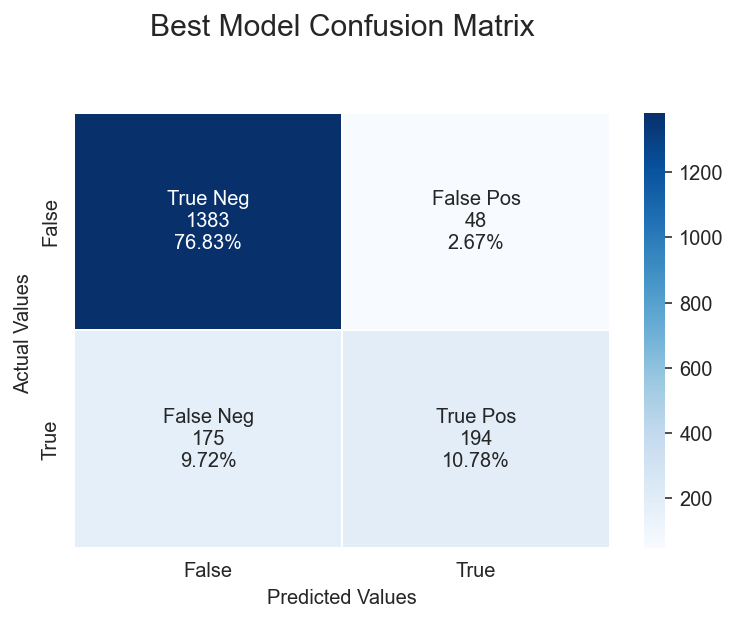

In [77]:
cm = confusion_matrix(y_test, best_model_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_sum = ['{0:0.0F}'.format(value) for value in cm.flatten()]

group_percent = ['{0:.2%}'.format(value) for value in 
                 cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
         zip(group_names, group_sum, group_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', linewidths=0.75, cmap='Blues')

ax.set_title('Best Model Confusion Matrix\n\n', size=15);
ax. set_xlabel("Predicted Values")
ax. set_ylabel('Actual Values ');
#
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True']);

### Classification Report

In [78]:
cr = classification_report(y_test, best_model_pred)
print(f'Best Model Classification Report\n\n{cr}')

Best Model Classification Report

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1431
           1       0.80      0.53      0.64       369

    accuracy                           0.88      1800
   macro avg       0.84      0.75      0.78      1800
weighted avg       0.87      0.88      0.87      1800



### Precision

In [79]:
precision = precision_score(y_test, best_model_pred) * 100
print(f'Best Model Precision test score: {precision:.4f}%')

Best Model Precision test score: 80.1653%


### Recall

In [80]:
recall = recall_score(y_test, best_model_pred) * 100
print(f'Best Model Recall test score: {recall:.4f}%')

Best Model Recall test score: 52.5745%


### Best Model Results

In [81]:
best_model_result = pd.DataFrame(columns=['CV ROC-AUC', 'ROC-AUC', 'Precision', 'Recall'], 
                                 index=['Tuned LogReg-Poly'])

best_model_result.loc['Tuned LogReg-Poly', 'CV ROC-AUC'] = round(best_model_score * 100, 3)
best_model_result.loc['Tuned LogReg-Poly', 'ROC-AUC'] = round(roc_auc, 3)
best_model_result.loc['Tuned LogReg-Poly', 'Precision'] = round(precision, 3)
best_model_result.loc['Tuned LogReg-Poly', 'Recall'] = round(recall, 3)
best_model_result

CV ROC-AUC ROC-AUC Precision  Recall
Tuned LogReg-Poly     85.103  88.208    80.165  52.575

    - The best model (tuned LogReg w/ Poly) achieved:
    
        - Mean CV ROC-AUC score of 85.103%
        - ROC-AUC test score of 88.208%
        - Precision test score of 80.165% 
        - Recall test score of 52.575% 

# 6. Conclusions

We have developed a resuable model pipeline, the optimized model is able to solve the business problem of predicting customer churn with given parameters. The model can be deployed - used to make predictions on new data.

Our Approach:

- We started out with a detailed exploratory data analysis of the data, analyzing the descriptive and target features.
- Next, we cleaned and prepared the data for machine learning.
    - Encoded the categorical features
    - We carried our feature engineering, creating three new features for the data
    - Split the data into training and testing sets
- We decided on models to use, our model evaluation strategy and metric selection
    - We settled on **ROC-AUC** metric since the target feature is imbalanced
    - We tried 4 different classifers
            - LogReg
            - LogReg with Polynominal Features
            - Random Forest
            - History Gradient Boosting
- We compare and evaluate models results choosing best model (**LogReg-Poly**) and tuned hyperparameters.
- We inspect best model (**Tuned LogReg-Poly**) predicitons on hold-out test set.

In [82]:
model_results = pd.concat([model_results, best_model_result], axis=0)
model_results.sort_values(by=['CV ROC-AUC'], ascending=False, inplace=True)
model_results

CV ROC-AUC  ROC-AUC Precision   Recall
Tuned LogReg-Poly                   85.103   88.208    80.165   52.575
Default_LogReg-Poly                85.0504  87.9713    79.918  52.8455
Default_HistoryGradientBoosting     84.864  87.7359    78.629  52.8455
Default_RandomForest               84.2341  85.9377    78.733  47.1545
Default_LogReg                     76.7057  78.4133   73.7705  24.3902

In [83]:
model_results['CV ROC-AUC'].iplot(kind='bar',
                                 title='<b>Model Comparison by CV ROC-AUC<b>')

The aim is to predict the customers that will possibly churn so they can be put in some sort of scheme to prevent churn hence the recall measures on the 1's is of most important, more so than the overall CV ROC-AUC score of the model.

Earlier during EDA, we noted that we had about 20% of churn, a recall greater than this baseline will already be an improvement, but we want to get as high as possible while also trying to maintain a high precision so that the bank can train its resources effectively towards clients highlighted by the model without wasting too much resources on the false positives.

From the review of the fitted models above, the best model that gives a decent balance of the recall and precision is the **Tuned LogReg** model where according to the fit on the training set, with a **precision score** on 1's of **0.80**, out of all customers that the model thinks will churn, **80.17%** do actually churn and with the **recall score** of **0.52** on the 1's, the model is able to highlight **52.58%** of all those who churned.

The threshold that our model needs to reach depends on the business need. We can tune the model threshold to some extent to optimize for different metrics.

## 6.1 Tuning Decision Threshold

Precision Breakpoints

    - High Decision Threshold (0.9 - 1.0)
    - Medium Decision Threshold (0.8 - 0.9)
    - Low Decision Threshold (0.7 - 0.8) 

In [84]:
# revised class predictions using decision threshold 0.90
hgb_predprob_high = assign_class(best_model_predprob, dt=0.90)

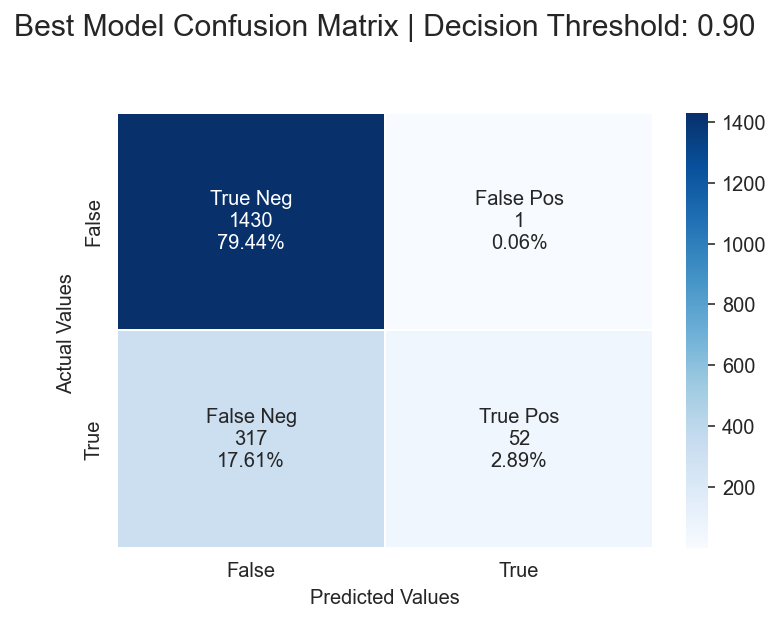

In [85]:
hgb_cm_high = confusion_matrix(y_test, hgb_predprob_high)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_sum = ['{0:0.0F}'.format(value) for value in hgb_cm_high.flatten()]

group_percent = ['{0:.2%}'.format(value) for value in 
                 hgb_cm_high.flatten()/np.sum(hgb_cm_high)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
         zip(group_names, group_sum, group_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(hgb_cm_high, annot=labels, fmt='', linewidths=0.75, cmap='Blues')

ax.set_title('Best Model Confusion Matrix | Decision Threshold: 0.90\n\n', size=15);
ax. set_xlabel("Predicted Values")
ax. set_ylabel('Actual Values ');
#
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True']);

In [86]:
hgb_cr_high = classification_report(y_test, hgb_predprob_high)
print(hgb_cr_high)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1431
           1       0.98      0.14      0.25       369

    accuracy                           0.82      1800
   macro avg       0.90      0.57      0.57      1800
weighted avg       0.85      0.82      0.77      1800



    - High Decision Threshold (0.9 - 1.0)
        - 98% Precision / 14% Recall (52 True Pos, 1 False Pos)

In [87]:
# revised class predictions using decision threshold 0.80
hgb_predprob_med = assign_class(best_model_predprob, dt=0.80)

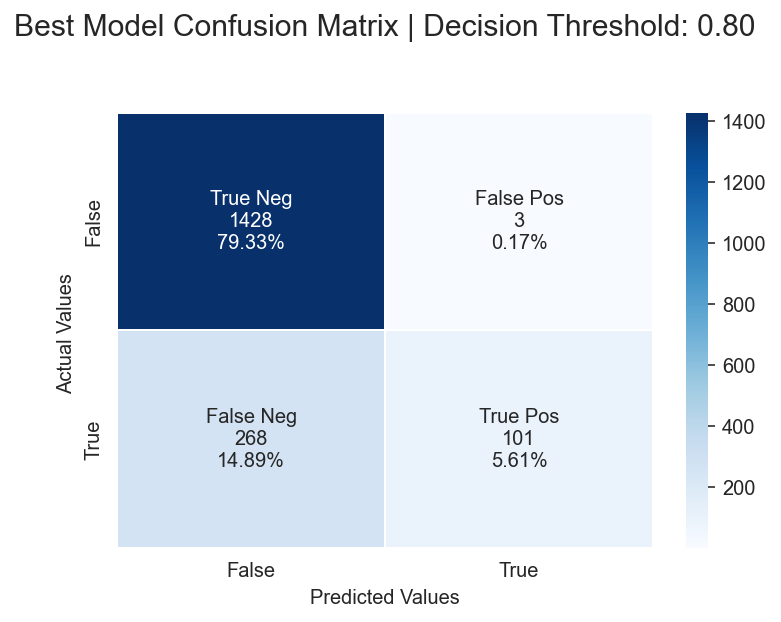

In [88]:
hgb_cm_med = confusion_matrix(y_test, hgb_predprob_med)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_sum = ['{0:0.0F}'.format(value) for value in hgb_cm_med.flatten()]

group_percent = ['{0:.2%}'.format(value) for value in 
                 hgb_cm_med.flatten()/np.sum(hgb_cm_med)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
         zip(group_names, group_sum, group_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(hgb_cm_med, annot=labels, fmt='', linewidths=0.75, cmap='Blues')

ax.set_title('Best Model Confusion Matrix | Decision Threshold: 0.80\n\n', size=15);
ax. set_xlabel("Predicted Values")
ax. set_ylabel('Actual Values ');
#
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True']);

In [89]:
hgb_cr_med = classification_report(y_test, hgb_predprob_med)
print(hgb_cr_med)

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1431
           1       0.97      0.27      0.43       369

    accuracy                           0.85      1800
   macro avg       0.91      0.64      0.67      1800
weighted avg       0.87      0.85      0.81      1800



    - Medium Decision Threshold (0.8 - 0.9)
        - 97% Precision / 27% Recall (101 True Pos, 3 False Pos)

In [90]:
# revised class predictions using decision threshold 0.70
hgb_predprob_low = assign_class(best_model_predprob, dt=0.70)

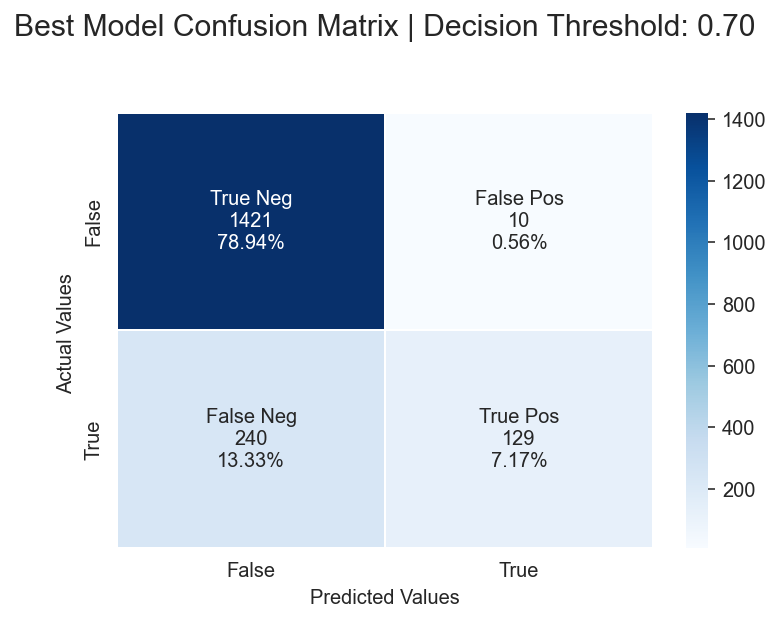

In [91]:
hgb_cm_low = confusion_matrix(y_test, hgb_predprob_low)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_sum = ['{0:0.0F}'.format(value) for value in hgb_cm_low.flatten()]

group_percent = ['{0:.2%}'.format(value) for value in 
                 hgb_cm_low.flatten()/np.sum(hgb_cm_low)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
         zip(group_names, group_sum, group_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(hgb_cm_low, annot=labels, fmt='', linewidths=0.75, cmap='Blues')

ax.set_title('Best Model Confusion Matrix | Decision Threshold: 0.70\n\n', size=15);
ax. set_xlabel("Predicted Values")
ax. set_ylabel('Actual Values ');
#
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True']);

In [92]:
hgb_cr_low = classification_report(y_test, hgb_predprob_low)
print(hgb_cr_low)

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1431
           1       0.93      0.35      0.51       369

    accuracy                           0.86      1800
   macro avg       0.89      0.67      0.71      1800
weighted avg       0.87      0.86      0.83      1800



    - Low Decision Threshold (0.7 - 0.8)
        - 93% Precision / 35% Recall (129 True Pos, 10 False Pos)

### Decision Threshold Summary:

    - High Decision Threshold (0.9 - 1.0) 
        - 98% Precision / 14% Recall (52 True Pos, 1 False Pos)
    - Medium Decision Threshold (0.8 - 0.9)
        - 97% Precision / 27% Recall (101 True Pos, 3 False Pos)
    - Low: Low Decision Threshold (0.7 - 0.8)
        - 93% Precision / 35% Recall (129 True Pos, 10 False Pos)
    - Normal Threshold (0.5)
        - 80% Precision / 53% Recall (194 True Pos, 48 False Pos)

## 6.2 Save Best Model

In [93]:
# Fit best model on all the data
best_model.fit(X, y);

In [94]:
import joblib
joblib.dump(best_model, '../03-model/customer-churn-bank-logregpoly-model-v1.pkl', compress=1)
print('Best Model Saved!!')

Best Model Saved!!


# 7. Model Testing

Let's test the best model on new unseen data (i.e. the test set we split off at the beginning). 

*Note, this test set is raw data (unpreprocessed) that the model has not seen yet. This is not the same as the testing set that was used to train the model.*

## 7.1 Load Model

First we need to load in the model.

In [95]:
model = joblib.load('../03-model/customer-churn-bank-logregpoly-model-v1.pkl')
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162c5cf40>),
                                                 ('categorical',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1629ef700>)])),
                ('feature_engineering', PolynomialFeatures()),
                ('model',
                 LogisticRegression(C=0.5, max_iter=472, penalty='l1',
                                    random_state=999, solver='liblinear',
                                    tol=1e-05))])

## 7.2 Import New Data

In [96]:
# Import new data
new_data = pd.read_csv('../02-data/customer-churn-bank-testingset.csv')

In [97]:
# Let's look at the new data
new_data.head()

RowNumber  CustomerId     Surname  CreditScore Geography  Gender  Age  \
0       9032    15742323      Barese          541    France    Male   39   
1       3463    15713596   Ugochukwu          428    France  Female   62   
2       3864    15645095       Huang          674    France  Female   28   
3       1145    15694821       Hardy          765   Germany    Male   43   
4       2693    15736274  Prokhorova          751    France    Male   31   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       7       0.00              2          1               0   
1       1  107735.93              1          0               1   
2       3       0.00              1          1               0   
3       4  148962.76              1          0               1   
4       8       0.00              2          0               0   

   EstimatedSalary  Exited  BalanceSalaryRatio  TenureByAge  \
0         19823.02       0            0.000000     0.179487   
1         58381.77       0            1.845369     0.016129   
2         51536.99       0            0.000000     0.107143   
3        173878.87       1            0.856704     0.093023   
4         17550.49       0            0.000000     0.258065   

   CreditScoreGivenAge  
0            13.871795  
1             6.903226  
2            24.071429  
3            17.790698  
4            24.225806

In [98]:
X_new = new_data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y_true = new_data['Exited']
print('The shape of X_new:', X_new.shape)
print('The shape of y_true:', y_true.shape)

The shape of X_new: (1000, 13)
The shape of y_true: (1000,)


## 7.3 Make Predictions

In [99]:
model_pred = model.predict(X_new)

In [100]:
predictions = pd.DataFrame({'ModelPrediction': model_pred, 'ActualResult': y_true})
predictions.head()

ModelPrediction  ActualResult
0                0             0
1                0             0
2                0             0
3                0             1
4                0             0

In [101]:
# Save test set predictions to a csv
predictions.to_csv('../02-data/customer-churn-bank-testingset-predictions.csv')

### Evaluate Predictions

Let's compare the predictions from the model to the actual result.

In [102]:
comparison = model_pred == y_true
np.unique(comparison, return_counts=True)

(array([False,  True]), array([130, 870]))

    - Out of 1000, the model correctly predicted 870 (87%) predictions, while 130 (13%) predictions the 
      model incorrectly predicted. 

### Confusion Matrix

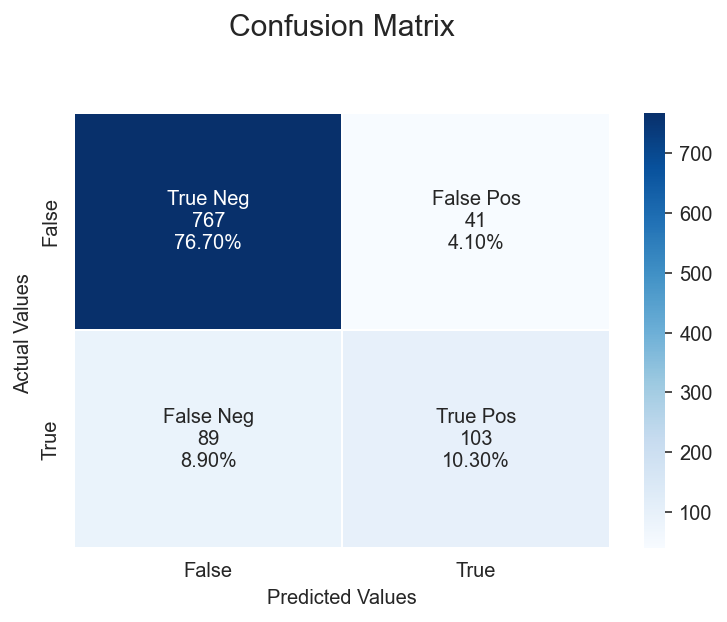

In [103]:
cm = confusion_matrix(y_true, model_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_sum = ['{0:0.0F}'.format(value) for value in cm.flatten()]

group_percent = ['{0:.2%}'.format(value) for value in 
                 cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
         zip(group_names, group_sum, group_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', linewidths=0.75, cmap='Blues')

ax.set_title('Confusion Matrix\n\n', size=15);
ax. set_xlabel("Predicted Values")
ax. set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True']);

### Classification Report

In [104]:
cr = classification_report(y_true, model_pred)
print(f'Classification Report\n\n{cr}')

Classification Report

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       808
           1       0.72      0.54      0.61       192

    accuracy                           0.87      1000
   macro avg       0.81      0.74      0.77      1000
weighted avg       0.86      0.87      0.86      1000



# 8. Reproducibility

In [105]:
%watermark -a 'Rainier Goubault' -n -m -v -iv 

Author: Rainier Goubault

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

plotly    : 5.4.0
numpy     : 1.21.4
sklearn   : 1.0.1
cufflinks : 0.17.3
scipy     : 1.7.3
pandas    : 1.3.4
joblib    : 1.1.0
matplotlib: 3.5.0
seaborn   : 0.11.2
json      : 2.0.9

